In [1]:
import numpy as np
from math import floor
import random

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from scipy.spatial.distance import jensenshannon

import leidenalg as la
import igraph as ig

try: 
    from graph_tool.all import *
except: 
    from infomap import Infomap, MultilayerNode

    import tensorly as tl
    from tensorly.decomposition import non_negative_parafac
    print('Graph-tool requires its own environment. Restart the kernel with a gt environment to run DSBM, otherwise you can proceed.')

In [2]:
class temporal_network:
    """
    Temporal network object to run dynamic community detection and other multilayer network diagnostics on. 
    Temporal network is a memoryless multiplex network where every node exists in every layer. 
    
    Attributes
    ------------
    temporal_network.size: int
        Number of nodes in any given layer.
    temporal_network.length: int
        Total number of layers.
    temporal_network.nodes: list
        A list of node ids starting from 0 to ``size-1``.
    temporal_network.windowsize: int
        Assuming that temporal network is created from a continous time-series data, windowsize is the size
        of the windows we are splitting the time-series into.
    temporal_network.supra_adjacency: array, ``size*length x size*length``
        The supra adjacency matrix to encode the connectivity information of the multilayer network.
    temporal_network.list_adjacency: list, [array1, array2, ...]
        A list of arrays of length ``length`` where each array is ``size x size`` encoding the connectivity 
        information of each layer.
    temporal_network.edge_list: list, [list1, list2, ...]
        A list of length ``length`` of lists where each element of the sublist is a 4-tuple (i,j,w,t) indicating
        there is an edge from node i to node j of nonzero weight w in the layer t. So, every quadruplet in the
        t'th sublist in ``edge_list`` has 4th entry t.
    
    Parameters
    ------------
    size: int
        Number of nodes in any given layer.
    length: int
        Total number of layers.
    window_size: int
        Size of the windows the time series will be divided into.
    data: str
        ``temporal_network`` accepts three types of connectivity input, ``supra_adjacency``, ``list_adjacency`` 
        and ``edge_list`` (see the attributes). So, we must specify which one of these types we are submitting 
        the connectivity information to the ``temporal_network``. Accordingly, this parameter can be one of the 
        ``supra__adjacency``, ``list__adjacency`` and ``edge__list``, respectively.
        
        Once the data type is understood, object converts the given input into the other two data types so that
        if it needs to use one of the other types(it is easier to work with ``list_adjacency`` for example, but 
        some helper functions from different libraries such as ``igraph``, processes ``edge_list`` better), 
        it can switch back and forth quicker.
    **kwargs:
        supra_adjacency: array, ``size*length x size*length``
            The supra adjacency matrix to encode the connectivity information of the multilayer network. Should 
            be provided if ``data = supra__adjacency``.
    **kwargs:
        list_adjacency: list, [array1, array2, ...]
            A list of arrays of length ``length`` where each array is ``size x size`` encoding the connectivity 
            information of each layer. Should be provided if ``data = list__adjacency``.
    **kwargs:
        edge_list: list, [list1, list2, ...]
            A list of length ``length`` of lists where each element of the sublist is a 4-tuple (i,j,w,t) 
            indicating there is an edge from node i to node j of nonzero weight w in the layer t. So, every 
            quadruplet in the t'th sublist in ``edge_list`` has 4th entry t. Should be provided if 
            ``data = edge__list``.
    **kwargs:
        omega: int
            Interlayer edge coupling strength. Should be provided if data is ``list__adjacency`` or 
            ``edge__list``. For now, we will assume all the coupling is going to be diagonal with a constant 
            strength.
            
            TODO: extend omega to a vector(for differing interlayer diagonal coupling strengths) and to
            a matrix(for non-diagonal coupling).
    **kwargs:
        kind:
            Interlayer coupling type. Can be either ``ordinal`` where only the adjacent layers are coupled or 
            ``cardinal`` where all layers are pairwise coupled with strength ``omega``. Should be provided if 
            data is ``list__adjacency`` or ``edge__list``.
    
    """
    def __init__(self, size, length, window_size, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        self.windowsize = window_size
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
    
    def binarize(self, array, thresh = None):
        n,t = array.shape
        binary_spikes = np.zeros(array.shape)
        for i in range(n):
            for j in range(t):
                if thresh is None:
                    if array[i][j] <= 0: pass
                    else: binary_spikes[i][j] = 1
                else:
                    if array[i][j] < thresh: array[i][j] = 0
                    else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def threshold(self, array, thresh):
        n,t = array.shape
        thresholded_array = np.copy(array)
        for i in range(n):
            for j in range(t):
                if array[i][j] < thresh: thresholded_array[i][j] = 0
                else: pass
        return(thresholded_array)
    
    def bin_time_series(self, array, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        
        binsize = self.windowsize
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        gauss_array = np.zeros((n,totalsize))
        l = int(totalsize/binsize) # number of resulting layers
        
        if gaussian:
            for i in range(n):
                gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
        else: gauss_array= array
            
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
        return(A)
    
    def edgelist2edges(self):# helper to create igraphs
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self, node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))
    
    def get_attrs_or_nones(self, seq, attr_name):
        try:
            return seq[attr_name]
        except KeyError:
            return [None] * len(seq)
    
    def disjoint_union_attrs(self, graphs):
        G = ig.Graph.disjoint_union(graphs[0], graphs[1:])
        vertex_attributes = set(sum([H.vertex_attributes() for H in graphs], []))
        edge_attributes = set(sum([H.edge_attributes() for H in graphs], []))

        for attr in vertex_attributes:
            attr_value = sum([self.get_attrs_or_nones(H.vs, attr) for H in graphs], [])
            G.vs[attr] = attr_value
        for attr in edge_attributes:
            attr_value = sum([self.get_attrs_or_nones(H.es, attr) for H in graphs], [])
            G.es[attr] = attr_value
        return G

    def time_slices_to_layers(self, graphs, interlayer_indices, interlayer_weights,
                              interslice_weight=1,
                              slice_attr='slice',
                              vertex_id_attr='id',
                              edge_type_attr='type',
                              weight_attr='weight'):
    
        G_slices = ig.Graph.Tree(len(graphs), 1, mode=ig.TREE_UNDIRECTED)
        G_slices.es[weight_attr] = interslice_weight
        G_slices.vs[slice_attr] = graphs
    
        return self.slices_to_layers(G_slices, interlayer_indices, interlayer_weights, slice_attr,vertex_id_attr,edge_type_attr,weight_attr)

    def slices_to_layers(self, G_coupling, interlayer_indices, interlayer_weights,
                         slice_attr='slice',
                         vertex_id_attr='id',
                         edge_type_attr='type',
                         weight_attr='weight'):
        
        if not slice_attr in G_coupling.vertex_attributes():
            raise ValueError("Could not find the vertex attribute {0} in the coupling graph.".format(slice_attr))

        if not weight_attr in G_coupling.edge_attributes():
            raise ValueError("Could not find the edge attribute {0} in the coupling graph.".format(weight_attr))

        # Create disjoint union of the time graphs
        for v_slice in G_coupling.vs: 
            H = v_slice[slice_attr]
            H.vs[slice_attr] = v_slice.index
            if not vertex_id_attr in H.vertex_attributes():
                raise ValueError("Could not find the vertex attribute {0} to identify nodes in different slices.".format(vertex_id_attr ))
            if not weight_attr in H.edge_attributes():
                H.es[weight_attr] = 1

        G = self.disjoint_union_attrs(G_coupling.vs[slice_attr])
        G.es[edge_type_attr] = 'intraslice'

        for i in range(len(G_coupling.vs[slice_attr])-1):
            v_slice = G_coupling.vs[i]
            nodes_v = sorted([v for v in G.vs if v[slice_attr] == v_slice.index and v[vertex_id_attr] in G.vs.select(lambda v: v[slice_attr]==v_slice.index)[vertex_id_attr]], key=lambda v: v[vertex_id_attr])
            for j,v in enumerate(nodes_v):
                w, nbr = self.neighborhood_flow(i, j, interlayer_indices, interlayer_weights, thresh = 0.2)
                edges = []
                a = G.vs[int(i*self.size + j)]
                for n in nbr:
                    b = G.vs[int((i+1)*self.size + n)]
                    edges.append((a,b))
                e_start = G.ecount()
                G.add_edges(edges)
                e_end = G.ecount()
                e_idx = range(e_start,e_end)
                G.es[e_idx][weight_attr] = w
                G.es[e_idx][edge_type_attr] = 'interslice'

        # Convert aggregate graph to individual layers for each time slice.
        G_layers = [None]*G_coupling.vcount()
        for v_slice in G_coupling.vs:
            H = G.subgraph_edges(G.es.select(_within=[v.index for v in G.vs if v[slice_attr] == v_slice.index]), delete_vertices=False)
            H.vs['node_size'] = [1 if v[slice_attr] == v_slice.index else 0 for v in H.vs]
            G_layers[v_slice.index] = H

        # Create one graph for the interslice links.
        G_interslice = G.subgraph_edges(G.es.select(type_eq='interslice'), delete_vertices=False)
        G_interslice.vs['node_size'] = 0
    
        return G_layers, G_interslice, G
    
    def create_igraph(self):
        T = self.length
        N = self.size
        G = []
        edges = self.edgelist2edges()[0]
        weights = self.edgelist2edges()[1]
        for i in range(T):
            G.append(ig.Graph())
            G[i].add_vertices(N)
            G[i].add_edges(edges[i])
            G[i].es['weight'] = weights[i]
            G[i].vs['id'] = list(range(N))
            G[i].vs['node_size'] = 0
        return(G)

    
    def leiden(self, G, interslice, resolution):
        
        layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
        
        partitions = [la.RBConfigurationVertexPartition(H, 
                                            weights = 'weight', 
                                            resolution_parameter = resolution) for H in layers]
        
        interslice_partition = la.RBConfigurationVertexPartition(interslice_layer, 
                                                                 weights = 'weight',
                                                                 resolution_parameter = 0)
                                                     
        optimiser = la.Optimiser()
        
        diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])

        return(partitions, interslice_partition)
    
    def infomap(self, inter_edge, threshold, update_method = None, **kwargs):
        '''
        Infomap helper function. 
        '''
        im = Infomap("--two-level --directed --silent")
            ######### Make Network
            ## add intra edges
        thresholded_adjacency = []
        for l in range(self.length):
            thresholded_adjacency.append(self.threshold(self.list_adjacency[l], thresh = threshold))
            for n1,e in enumerate(thresholded_adjacency[l]):## list of length 2 corresponding to the adjacency matrices in each layer
                for n2,w in enumerate(e):
                    s = MultilayerNode(layer_id = l, node_id = n1)
                    t = MultilayerNode(layer_id = l, node_id = n2)
                    im.add_multilayer_link(s, t, w)
                    im.add_multilayer_link(t, s, w)
                
        ## add inter edges
        if update_method == 'local' or update_method == 'global': 
        
            updated_interlayer = self.update_interlayer(kwargs['spikes'], 0, inter_edge, 0.1, update_method) 
        
            for l in range(self.length-1):
                for k in range(self.size):# number of nodes which is 60 in the multilayer network
                    s = MultilayerNode(layer_id = l, node_id = k)
                    t = MultilayerNode(layer_id = l+1, node_id = k)
                    im.add_multilayer_link(s, t, updated_interlayer[l][k])
                    im.add_multilayer_link(t, s, updated_interlayer[l][k])
                
        elif update_method == 'neighborhood':
        
            updated_interlayer_indices, updated_interlayer_weights = self.get_normalized_outlinks(thresholded_adjacency, inter_edge)
            for l in range(self.length-1):
                for k in range(self.size):
                    w, nbr = self.neighborhood_flow(l, k, updated_interlayer_indices, updated_interlayer_weights, threshold)
                    for n in nbr:
                        s = MultilayerNode(layer_id = l, node_id = k)
                        t = MultilayerNode(layer_id = l+1, node_id = n)
                        im.add_multilayer_link(s, t, w)
                        im.add_multilayer_link(t, s, w)
                    
        elif update_method == None:
            for l in range(self.length-1):
                for k in range(self.size):# number of nodes which is 60 in the multilayer network
                    s = MultilayerNode(layer_id = l, node_id = k)
                    t = MultilayerNode(layer_id = l+1, node_id = k)
                    im.add_multilayer_link(s, t, inter_edge)
                    im.add_multilayer_link(t, s, inter_edge)
        
        im.run()
        return(im)
    
    def membership(self, interslice_partition): ## returns the community assignments from the leiden algorithm as
        ##                                       tuple (n,t) n is the node id t is the layer that node is in
        n = self.size
        membership = [[] for i in range(interslice_partition._len)]
        for i,m in enumerate(interslice_partition._membership):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))
        return(membership, len(membership))
    
    def community(self, membership, ax):
        n = self.size
        t = self.length
        number_of_colors = len(membership)

        comms = np.zeros((n,t))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
        return(comms, color)
    
    def raster_plot(self, spikes, ax, color = None, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        binsize = self.windowsize
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, gaussian = False)
        l,n,t = binned_spikes.shape
                    
        sp = np.nonzero(binned_spikes)
        
        if color is None: 
            col = [0]*l
            clr = [col for i in range(n)]
            color = ['#0000ff']
        else: clr = kwargs['comm_assignment']
        
        cmap = mpl.colors.ListedColormap(color)
        
        for i in range(len(sp[0])):
            ax.scatter(sp[0][i]*binsize+sp[2][i],  sp[1][i], 
                       s = 5, 
                       c = color[int(clr[sp[1][i]][sp[0][i]])], 
                       marker = 'x', 
                       cmap = cmap)
            
        ax.set_title('Raster Plot', fontsize = 20)
        ax.set_xlabel('Time (Frames)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_xticks([t*i for i in range(l+1)])
        ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
        ax.tick_params(axis = 'x', labelsize = 10)
        ax.tick_params(axis = 'y', labelsize = 13)
    
    def trajectories(self, thresh = 0.9, node_id = None, community = None, edge_color = True, pv = None):
        #function graphing the edge trajcetories of the temporal
        ## network. Tresh is for thresholding the paths that are strongere than the given value.
        ## if node_id is None, function is going to graph all of the nodes's trajectories.
        ## community argument is for indicating the community assignment
        ## of the nodes if exists, if not pass along None.
        ## edge_color
        ## pv == pass a list of pv cell indices or None --dashes the pv cells
        
        layers = []

        if edge_color == True: ed_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]
        else: e_color = 'black' #["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]

            
        if community is None: node_color = 'r'     
        else:
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(int(np.max(community)))]
            comap = mpl.colors.ListedColormap(colors)
            node_color = community
            norm = plt.Normalize(0,int(np.max(community)))

        if node_id == None:
            for k in self.nodes:
                for j in range(1,self.length):
                    for i in self.neighbors(k, j):
                        if self.list_adjacency[j][k][i] > thresh:
                            layers.append((j-1, j))
                            layers.append((k, i))
                            try: layers.append('%s' %ed_color[j])
                            except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1,1,figsize = (20,10))
            plt.plot(*layers,figure = fig)
            plt.title('Temporal trajectories of all the cells that are stronger than %f'%(thresh), fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)


            for i in range(self.size):
                x = np.linspace(0, self.length -1, self.length)
                y = np.linspace(i,i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)


        else:
            for j in range(1,self.length):
                for i in self.neighbors(node_id,j):
                    if self.list_adjacency[j][node_id][i] > thresh:
                        layers.append((j-1, j))
                        layers.append((node_id, i))
                        try: layers.append('%s' %ed_color[j])
                        except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1, 1, figsize = (20,10))
            plt.plot(*layers, figure = fig)
            plt.title('Temporal trajectories of the cell %d that are stronger than %f'%(node_id,thresh), fontsize = 20)
            plt.xlabel('Layers', fontsize = 15)
            plt.ylabel('Nodes', fontsize = 15)
            
            for i in range(self.size):
                x = np.linspace(0, self.length-1, self.length)
                y = np.linspace(i, i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)
        
        if community is not None:
            cbar = plt.colorbar(cmap = cmap)
        
            cbar.set_ticks([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_ticklabels([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_label('Colorbar for node communities - total of %d communities'%int(np.max(community)), rotation = 270)
        if pv is not None:
            plt.hlines(pv, 0, self.length-1, color = 'b', alpha = 0.4, linestyle = 'dashed')
            plt.yticks(pv, color = 'b')
        plt.tight_layout()
    
    def get_normalized_outlinks(self, thresholded_adjacency, interlayer): 
        #interlayer is the node itselves edge weight that is connected to its future self that is the maximal
        interlayer_indices = {}
        interlayer_weights = {}
        for i in range(self.length):
            layerweights = []
            for j in range(self.size):
                maximal_neighbors = [[int(interlayer),j]]
                for nonzero in np.nonzero(thresholded_adjacency[i][j,:])[0]:
                    maximal_neighbors.append([thresholded_adjacency[i][j,nonzero], nonzero])
                weights = np.array(sorted(maximal_neighbors, reverse = True))[:,0]
                indices = np.array(sorted(maximal_neighbors, reverse = True))[:,1]
                norm_weights = weights/np.sum(weights)
                indices, norm_weights
                interlayer_indices['%d,%d'%(i,j)] = indices
                interlayer_weights['%d,%d'%(i,j)] = norm_weights
        return(interlayer_indices,interlayer_weights)
    
    def neighborhood_flow(self, layer, node, interlayer_indices, interlayer_weights, thresh):
        length = int(min(len(interlayer_weights['%d,%d'%(layer,node)]),len(interlayer_weights['%d,%d'%(layer+1,node)]))*thresh)
        w = 1-jensenshannon(interlayer_weights['%d,%d'%(layer,node)][:length],interlayer_weights['%d,%d'%(layer+1,node)][:length])**2
        nbr = interlayer_indices['%d,%d'%(layer,node)][:length]
        return(w,nbr)
        
        
    def update_interlayer(self, spikes, X, omega_global, percentage, method):
        
        ## all three methods in this function assumes the diagonal coupling
        ## i.e. output is the list(of length layers -1) of lists (each of length number of neuorns)
        ## corresponding to a node's interlayer coupling strength with it's future self.
        binned_spikes = self.bin_time_series(spikes, gaussian = False)
        sp = np.nonzero(binned_spikes)
        
        layers ,num_neurons, t = self.length, self.size, self.windowsize
        
        count_spikes = np.zeros((layers, num_neurons))
        interlayer = np.ones((layers-1, num_neurons))
    
        if method == 'local':
            for i in range(len(sp[0])):
                l, n, t = sp[0][i], sp[1][i], sp[2][i]
                count_spikes[l][n] = count_spikes[l][n] + 1
            interlayers = []
            for i in range(layers-1):
                zscores = zscore(np.diff(count_spikes, axis = 0)[i])
                layerweights = []
                for j in range(num_neurons):
                    if zscores[j] <= X: layerweights.append(percentage*omega_global)
                    else: layerweights.append(omega_global)
                interlayers.append(layerweights)

        elif method == 'global':
            for i in range(len(sp[0])):
                l, n, t = sp[0][i], sp[1][i], sp[2][i]
                count_spikes[l][n] = count_spikes[l][n] + 1
            interlayers = []
            zscores = zscore(sum(np.diff(count_spikes, axis = 0)))
            for i in range(layers-1):
                layerweights = []
                for j in range(num_neurons):
                    if zscores[j] <= X: layerweights.append(percentage*omega_global)
                    else: layerweights.append(omega_global)
                interlayers.append(layerweights)
        return(interlayers)
    
    def make_tensor(self, rank, threshold, update_method, **kwargs):
        
        #Make tensor according to one of four methods
        if update_method == 'local' or update_method == 'global': 
            tensor = np.zeros((self.size, self.size, int((2*self.length)-1)))
            inters = self.update_interlayer(kwargs['spikes'], 0.5, 1, 0.01, update_method)
            for i in range(int((2*self.length)-1)):
                if i%2 == 0:
                    tensor[:,:,i] = self.threshold(self.list_adjacency[int(i/2)], threshold)
                else:
                    tensor[:,:,i] = np.diag(inters[int((i-1)/2)])
            X = tl.tensor(tensor)
        
        elif update_method == 'neighborhood':
            tensor = np.zeros((self.size, self.size, int((2*self.length)-1)))
            updated_interlayer_indices, updated_interlayer_weights = self.get_normalized_outlinks(self.list_adjacency, 1)
            for i in range(int((2*self.length)-1)):
                if i%2 == 0:
                    tensor[:,:,i] = self.threshold(self.list_adjacency[int(i/2)], threshold)
                else:
                    inter_layer = np.zeros((self.size,self.size))
                    for k in range(self.size):
                        w, nbr = self.neighborhood_flow(int(i/2), k, updated_interlayer_indices, updated_interlayer_weights, threshold)
                        if np.isnan(w):
                            w = 1.0
                        for n in nbr:
                            inter_layer[k,int(n)] = w
                    tensor[:,:,i] = inter_layer
            X = tl.tensor(tensor)
    
        elif update_method == None:
            tensor = np.zeros((self.size, self.size, int((2*self.length)-1)))
            for i in range(self.length):
                tensor[:,:,i] = self.threshold(self.list_adjacency[i], threshold)
            X = tl.tensor(tensor)
            
        #solve for PARAFAC decomposition
        weights_parafac, factors_parafac = non_negative_parafac(X, rank = rank, n_iter_max = 500, init = 'random')

        return(weights_parafac, factors_parafac)
    
    def process_tensor(self, factors, rank):
        comms = []
        membership = [[] for r in range(rank)]
        for i in range(self.length):
            for j in range(self.size):
                comm_id = np.argmax(((factors[0][j]+factors[1][j])/2)*factors[2][i])
                comms.append(comm_id)
                membership[comm_id].append((j,i))
        return(membership, comms)
    
    def process_matrices(self, threshs):
        processed_matrices = {}
        for k, f in enumerate(threshs):
            edge_lists = [[] for i in range(self.length)]
            for i in range(self.length):
                A = padded_adjacencies[i]
                firing = np.transpose(np.nonzero(np.triu(A)))
                for j,m in enumerate(firing):
                    if A[m[0],m[1]]<f: pass
                    else: 
                        quadreplet =(m[0], m[1], A[m[0], m[1]], i)
                        edge_lists[i].append(quadreplet)
            processed_matrices['%.2f'%f] = edge_lists
        return(processed_matrices)
    
    def dsbm_via_graphtool(self, edge_list, deg):
        graphs = []

        g = Graph()
        graphs.append(g)
        graphs[0].add_vertex(self.size)
        e_weight = graphs[0].new_ep("double")
        e_layer = graphs[0].new_ep("int")
        n_id = graphs[0].new_vp("int", vals = [i for i in range(self.size)])
        graphs[0].add_edge_list(edge_list[0], eprops=[e_weight, e_layer])
        graphs[0].edge_properties["edge_weight"] = e_weight
        graphs[0].edge_properties["edge_layer"] = e_layer
    
    
        G = graphs[0]

        for l in range(1,self.length):
            g = Graph()
            graphs.append(g)
            graphs[l].add_vertex(self.size)
            e_weight = graphs[l].new_ep("double")
            e_layer = graphs[l].new_ep("int")
            n_id = graphs[l].new_vp("int", vals = [i for i in range(self.size)])
            graphs[l].add_edge_list(edge_list[l], eprops=[e_weight, e_layer])
            graphs[l].edge_properties["edge_weight"] = e_weight
            graphs[l].edge_properties["edge_layer"] = e_layer
        
            G = graph_union(G, graphs[l], include = False, internal_props = True)

        state = LayeredBlockState(G, deg_corr = deg, ec = G.ep.edge_layer,  recs=[G.ep.edge_weight], rec_types=["real-exponential"],  layers = True, overlap = True)
    
        labels = [comm_id for comm_id in state.get_nonoverlap_blocks()]
        
        number_of_colors = len(np.unique(labels))
        membership = [[] for i in range(number_of_colors)]
        for i in range(self.size):#(num_neurons*layers):
            for j in range(self.length):
                node_id = labels[j*self.size+i]
                membership[node_id].append((i,j))
        return(membership, labels)
        
    
    def community_consensus_iterative(self, C):
        ## function finding the consensus of a given set of partitions. refer to the paper:
        ## 'Robust detection of dynamic community structure in networks', Danielle S. Bassett, 
        ## Mason A. Porter, Nicholas F. Wymbs, Scott T. Grafton, Jean M. Carlson et al.
        
        
        npart,m  = C.shape 
        C_rand3 = np.zeros((C.shape)) #permuted version of C
        X = np.zeros((m,m)) #Nodal association matrix for C
        X_rand3 = X # Random nodal association matrix for C_rand3

        # randomly permute rows of C
        for i in range(npart):
            C_rand3[i,:] = C[i,np.random.permutation(m)]
            for k in range(m):
                for p in range(m):
                    if int(C[i,k]) == int(C[i,p]): X[p,k] = X[p,k] + 1 #(i,j) is the # of times node i and j are assigned in the same comm
                    if int(C_rand3[i,k]) == int(C_rand3[i,p]): X_rand3[p,k] = X_rand3[p,k] + 1 #(i,j) is the # of times node i and j are expected to be assigned in the same comm by chance
        #thresholding
        #keep only associated assignments that occur more often than expected in the random data

        X_new3 = np.zeros((m,m))
        X_new3[X>(np.max(np.triu(X_rand3,1)))/2] = X[X>(np.max(np.triu(X_rand3,1)))/2]
        
        ##turn thresholded nodal association matrix into igraph
        edge_list = []
        weight_list = []
        for k,e in enumerate(np.transpose(np.nonzero(X_new3))):
            i,j = e[0], e[1]
            pair = (i,j)
            edge_list.append(pair)
            weight_list.append(X_new3[i][j])
        
        G = ig.Graph()
        G.add_vertices(m)
        G.add_edges(edge_list)
        G.es['weight'] = weight_list
        G.vs['id'] = list(range(m))
        
        optimiser = la.Optimiser()
        partition = la.ModularityVertexPartition(G, weights = 'weight')
        diff = optimiser.optimise_partition(partition, n_iterations = -1)
        
        return(partition)
    
    def run_community_detection(self, method, update_method = None, consensus = False, **kwargs):
        '''
        Main Function to run community detection.
        
        Parameters
        ===========
        method: str
            Either MMM, Infomap or PARA_FACT(Tensor Factorization) indicating the community detection method
        update_method: str
            Interlayer edges will be processed based on one of the three methods, either 
            local, global or neigborhood see `infomap`.
        consensus: bool
            Statistically significant partitions will be found from a given set of partitions.
        interlayers: 1-D array like
            A range of values for setting the interlayer edges of the network.
        resolutions: 1-D array like
            A range of values for the resolution parameters.
        thresholds: 1-D array like
            A range of values to threshold the network.
        spikes: 2-D array
            Initial array containing the spikes.
        
        '''
        
        if method == 'MMM':
            grid = len(kwargs['interlayers'])
            membership_partitions = {}
            C = np.zeros((grid*grid, self.size*self.length))
            for i,e in enumerate(kwargs['interlayers']):
                membership_labels = []
                igraphs = self.create_igraph()
    
                ##update interlayer edges
                if update_method == 'local' or update_method == 'global': 
            
                    inter_edge = self.update_interlayer(kwargs['spikes'], X = 0.5, omega_global = e, percentage = 0.01, method = update_method)    
                    for j,f in enumerate(kwargs['resolutions']):
                        parts, inter_parts = self.leiden(igraphs, inter_edge, f)
                    
                        C[i*grid+j,:] = inter_parts.membership
                        comm_labels, comm_size  = self.membership(inter_parts)
                        membership_labels.append(comm_labels)
                        
                elif update_method == 'neighborhood':
                    interlayer_indices, interlayer_weights = self.get_normalized_outlinks(self.list_adjacency, e)
                    for j,f in enumerate(kwargs['resolutions']):
                        layers, interslice_layer, G_full = self.time_slices_to_layers(igraphs, interlayer_indices, interlayer_weights, interslice_weight = e)
                        partitions = [la.RBConfigurationVertexPartition(H, weights = 'weight', resolution_parameter = f) for H in layers]
        
                        interslice_partition = la.RBConfigurationVertexPartition(interslice_layer, weights = 'weight', resolution_parameter = 0)
                                                     
                        optimiser = la.Optimiser()
        
                        diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])
                        C[i*grid+j,:] = interslice_partition.membership
                        comm_labels, comm_size  = self.membership(interslice_partition)
                        membership_labels.append(comm_labels)
                   
                elif update_method == None:
                    
                    for j,f in enumerate(kwargs['resolutions']):
                        parts, inter_parts = self.leiden(igraphs, e, f)
                    
                        C[i*grid+j,:] = inter_parts.membership
                        comm_labels, comm_size  = self.membership(inter_parts)
                        membership_labels.append(comm_labels)
                    
                membership_partitions['interlayer=%.3f'%e] = membership_labels
            
        elif method == 'infomap':
            grid = len(kwargs['interlayers'])
            membership_partitions = {}
            C = np.zeros((grid*grid, self.size*self.length))
            dtype = [('layer',int),('nodeid',int),('module', int)]

            for i, interlayer in enumerate(kwargs['interlayers']):
                inter_membership = []
                for j, thresh in enumerate(kwargs['thresholds']):
                    
                    IM = self.infomap(interlayer, thresh, update_method, **kwargs)
                    
                    membership = [[] for i in range(IM.num_top_modules)]
                    for node in IM.nodes:
                        membership[int(node.module_id-1)].append((node.node_id, node.layer_id))
                    inter_membership.append(membership)
        
                    ordered_set = []
                    for node in IM.nodes:
                        ordered_set.append((node.layer_id, node.node_id, node.module_id))
                    ordered_nodes = np.array(ordered_set , dtype = dtype)
                    
                    C[i*grid+j,:] = [node[2] for node in np.sort(ordered_nodes, order = ['layer', 'nodeid'])]
        
                membership_partitions['interlayer=%.3f'%interlayer] = inter_membership
        
        elif method == 'PARA_FACT':
            grid = len(kwargs['ranks'])
            membership_partitions = {}
            C = np.zeros((grid*grid, self.size*self.length))
            
            for i, r in enumerate(kwargs['ranks']):
                inter_membership = []
                for j, thresh in enumerate(kwargs['thresholds']):
                    weights, factors = self.make_tensor(r, thresh, update_method, **kwargs)
                    membership, comm  = self.process_tensor(factors, r)
                    inter_membership.append(membership)
                    C[i*grid+j,:] = comm
                membership_partitions['rank=%d'%r] = inter_membership
                
        elif method == 'DSBM':
            
            grid = len(kwargs['degree_correction'])
            membership_partitions = {}
            C = np.zeros((grid*grid, self.size*self.length))
            edge_list = self.process_matrices(kwargs['thresholds'])
            for i, deg in enumerate(kwargs['degree_correction']):
                inter_membership = []
                for j, thresh in enumerate(kwargs['thresholds']):
                    membership, comm  = self.dsbm_via_graphtool(edge_list['%.2f'%thresh], deg)
                    inter_membership.append(membership)
                    C[i*grid+j,:] = comm
                membership_partitions['degree_correction=%s'%deg] = inter_membership
        
        if consensus: 
            return(self.membership(self.community_consensus_iterative(C))[0], C)
        else: 
            return(membership_partitions, C)

In [3]:
from helpers import *

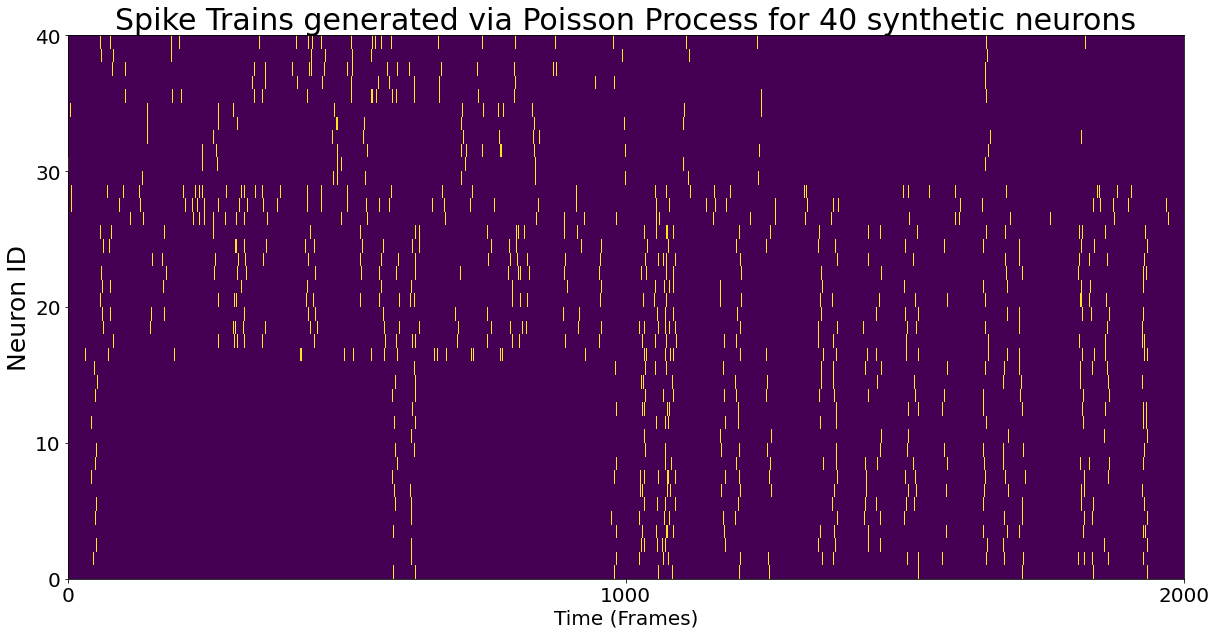

In [6]:
comms1 = 6
comms2 = 3

layers = 2

fixed_size = [int(abs(np.random.normal(20,10))*1/2) for i in range(comms1)]

comm_sizes = [fixed_size, #layer1 community sizes
              [fixed_size[0]+fixed_size[1]+fixed_size[2],fixed_size[3],fixed_size[4]+fixed_size[5]]] #layer2 community sizes
spike_rates = [[int(abs(np.random.normal(20,8))) for i in range(comms1)],#spikerates of the respective communities in layer5
              [int(abs(np.random.normal(20,8))) for i in range(comms2)]]#spikerates of the respective communities in layer6

window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
pad = True
num_neurons = int(sum(comm_sizes[0]))

spikes = create_time_series('merge', comm_sizes, spike_rates)

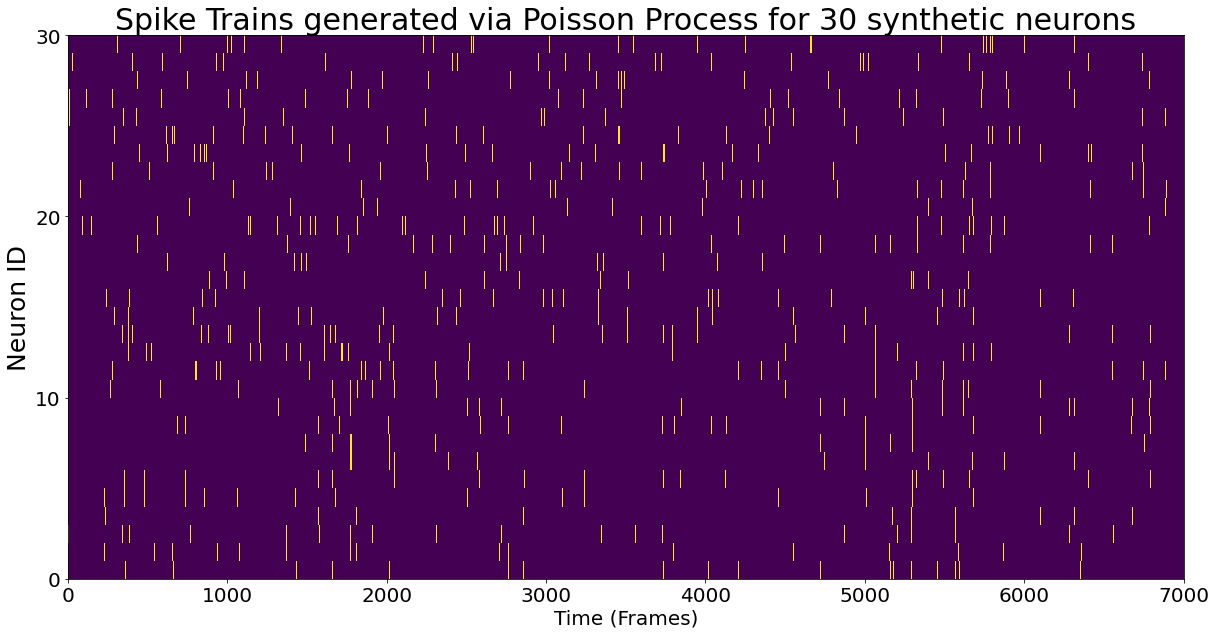

In [8]:
layers = 7
standard_dev = 1.2
window_size = 1000
pad = True

spike_rate = [int(abs(np.random.normal(20,8))) for i in range(layers)]# spike rate per commiunity
comm_size = [int(np.random.power(1/2)*20) for i in range(layers)]
num_neurons = sum(comm_size)
spikes = create_time_series('grow', comm_size, spike_rate)

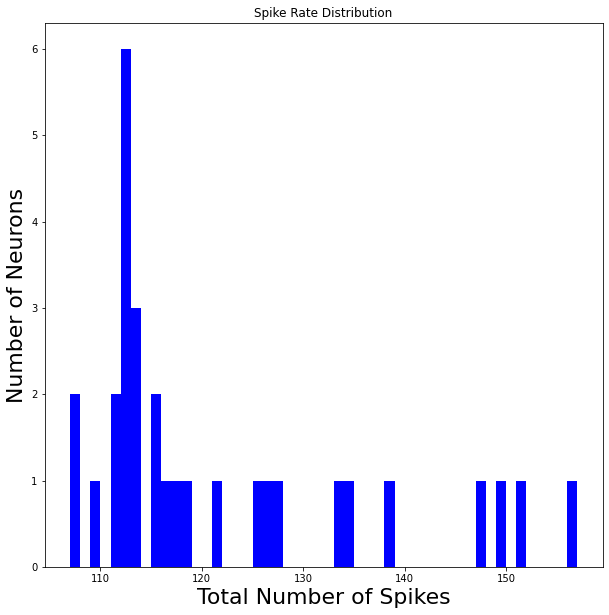

In [9]:
fig,ax = plt.subplots(1,1,figsize= (10,10))
n,bins = spike_count(spikes, ax)

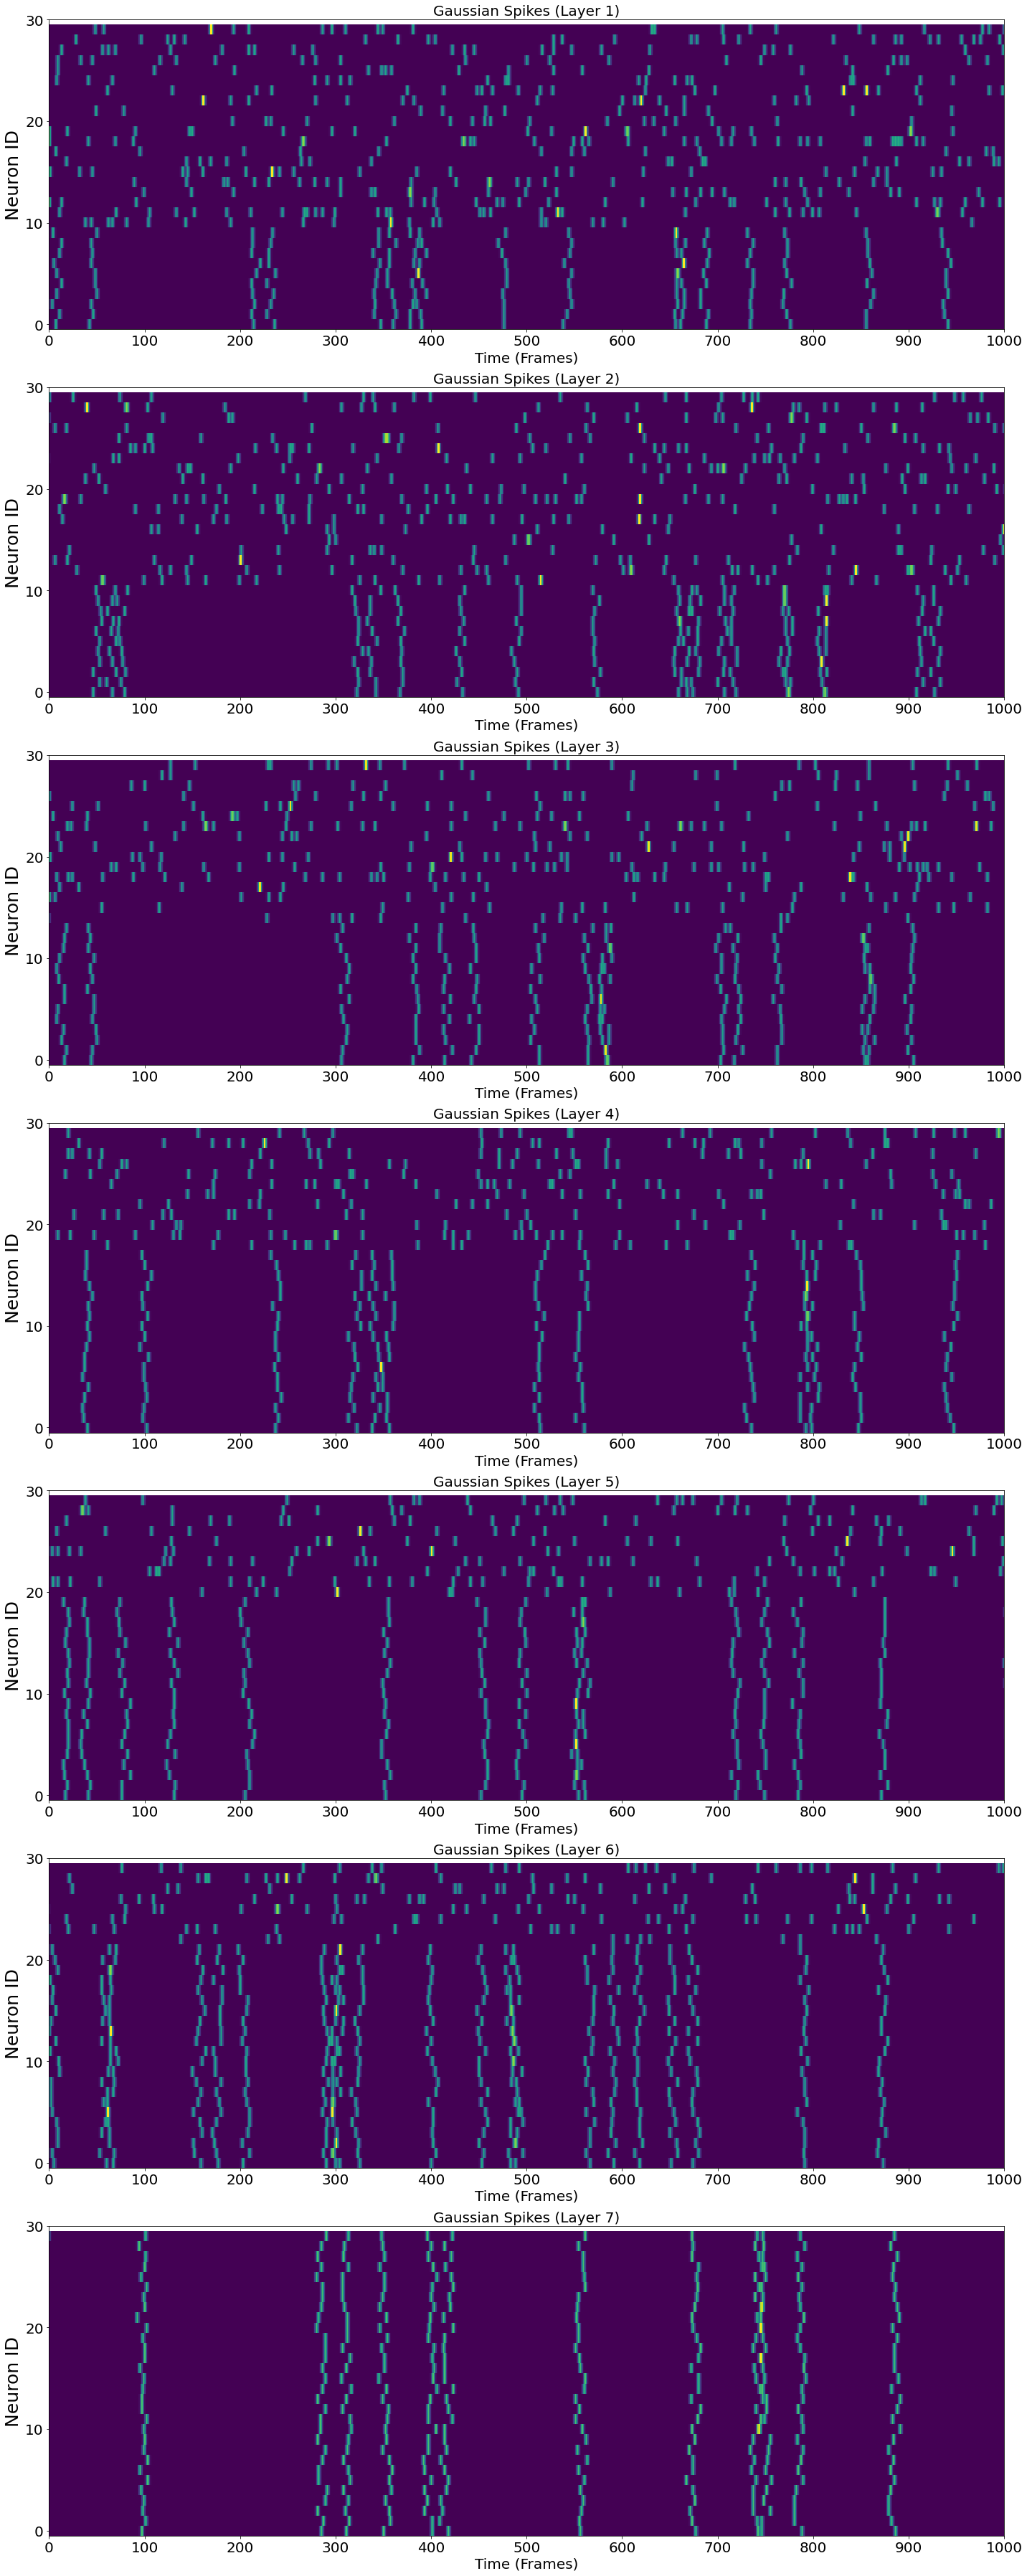

In [10]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(20,50))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

In [11]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])
    
if pad:
    padded_adjacencies = [adjacency_matrices[0]]  + adjacency_matrices + [adjacency_matrices[-1]]
    layers = layers + 2

/Users/bengieru/MLN/Base_Classes/helpers.py:33: RuntimeWarning: invalid value encountered in sqrt
  x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
/Users/bengieru/MLN/Base_Classes/helpers.py:34: RuntimeWarning: invalid value encountered in sqrt
  y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))


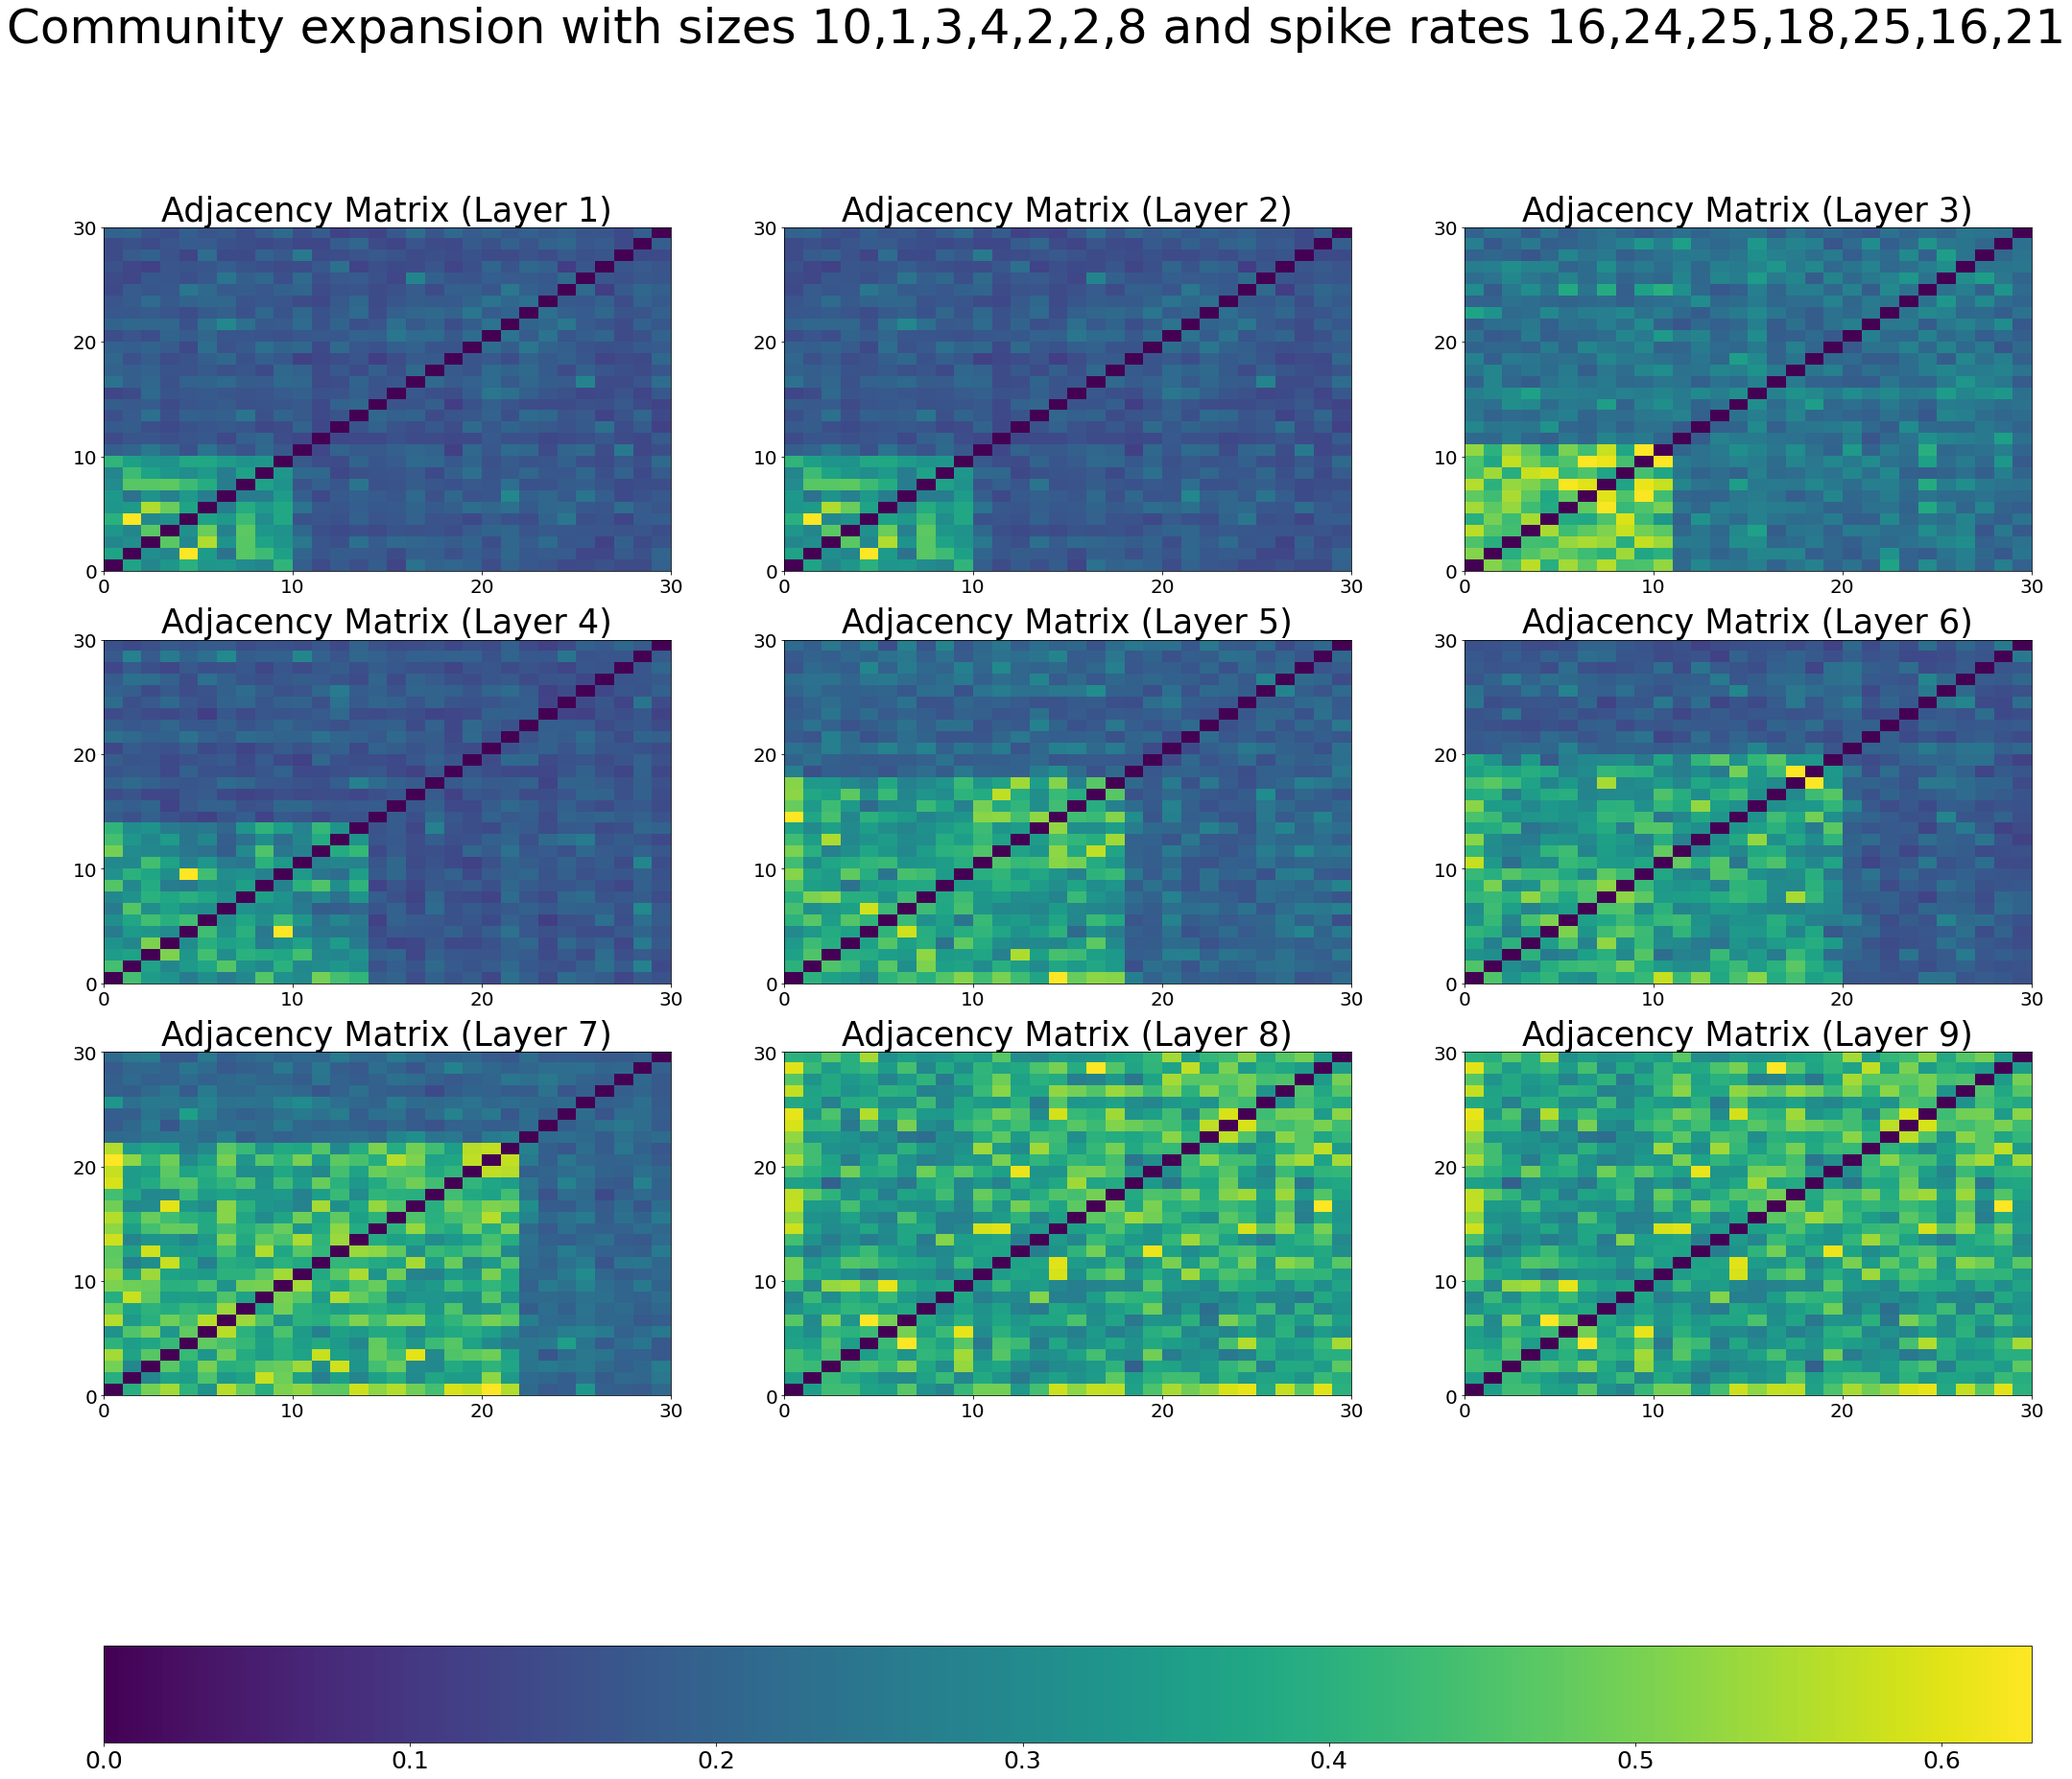

In [12]:
fig,ax = plt.subplots(3, 3, figsize = (36,32))
for i in range(3):
    for j in range(3):
        k = ax[i][j].imshow(padded_adjacencies[i*3+j], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
        ax[i][j].set_title('Adjacency Matrix (Layer %d)'%(i*3+j +1), fontsize = 35)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
fig.suptitle('Community expansion with sizes %d,%d,%d,%d,%d,%d,%d and spike rates %d,%d,%d,%d,%d,%d,%d'%(comm_size[0],comm_size[1],comm_size[2],comm_size[3],comm_size[4],comm_size[5],comm_size[6],spike_rate[0],spike_rate[1],spike_rate[2],spike_rate[3],spike_rate[4],spike_rate[5],spike_rate[6]), fontsize = 50)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

In [13]:
%%time
TN = temporal_network(num_neurons, 
                      layers, 
                      window_size, 
                      data = 'list__adjacency', 
                      list_adjacency = padded_adjacencies, 
                      omega = 1, 
                      kind = 'ordinal')
#fig,ax = plt.subplots(1,1, figsize = (25,15))
#TN.raster_plot(spikes, ax)

CPU times: user 14.6 ms, sys: 2.39 ms, total: 17 ms
Wall time: 15.8 ms


## Grow, DSBM, no update, no consensus

In [14]:
degs= [True, False]
threshs = np.linspace(0.2, 0.4, 2)

In [15]:
%%time
membership_no_update, labels_no_update = TN.run_community_detection('DSBM', degree_correction = degs, thresholds = threshs, consensus = False)

CPU times: user 1.74 s, sys: 139 ms, total: 1.88 s
Wall time: 1.06 s


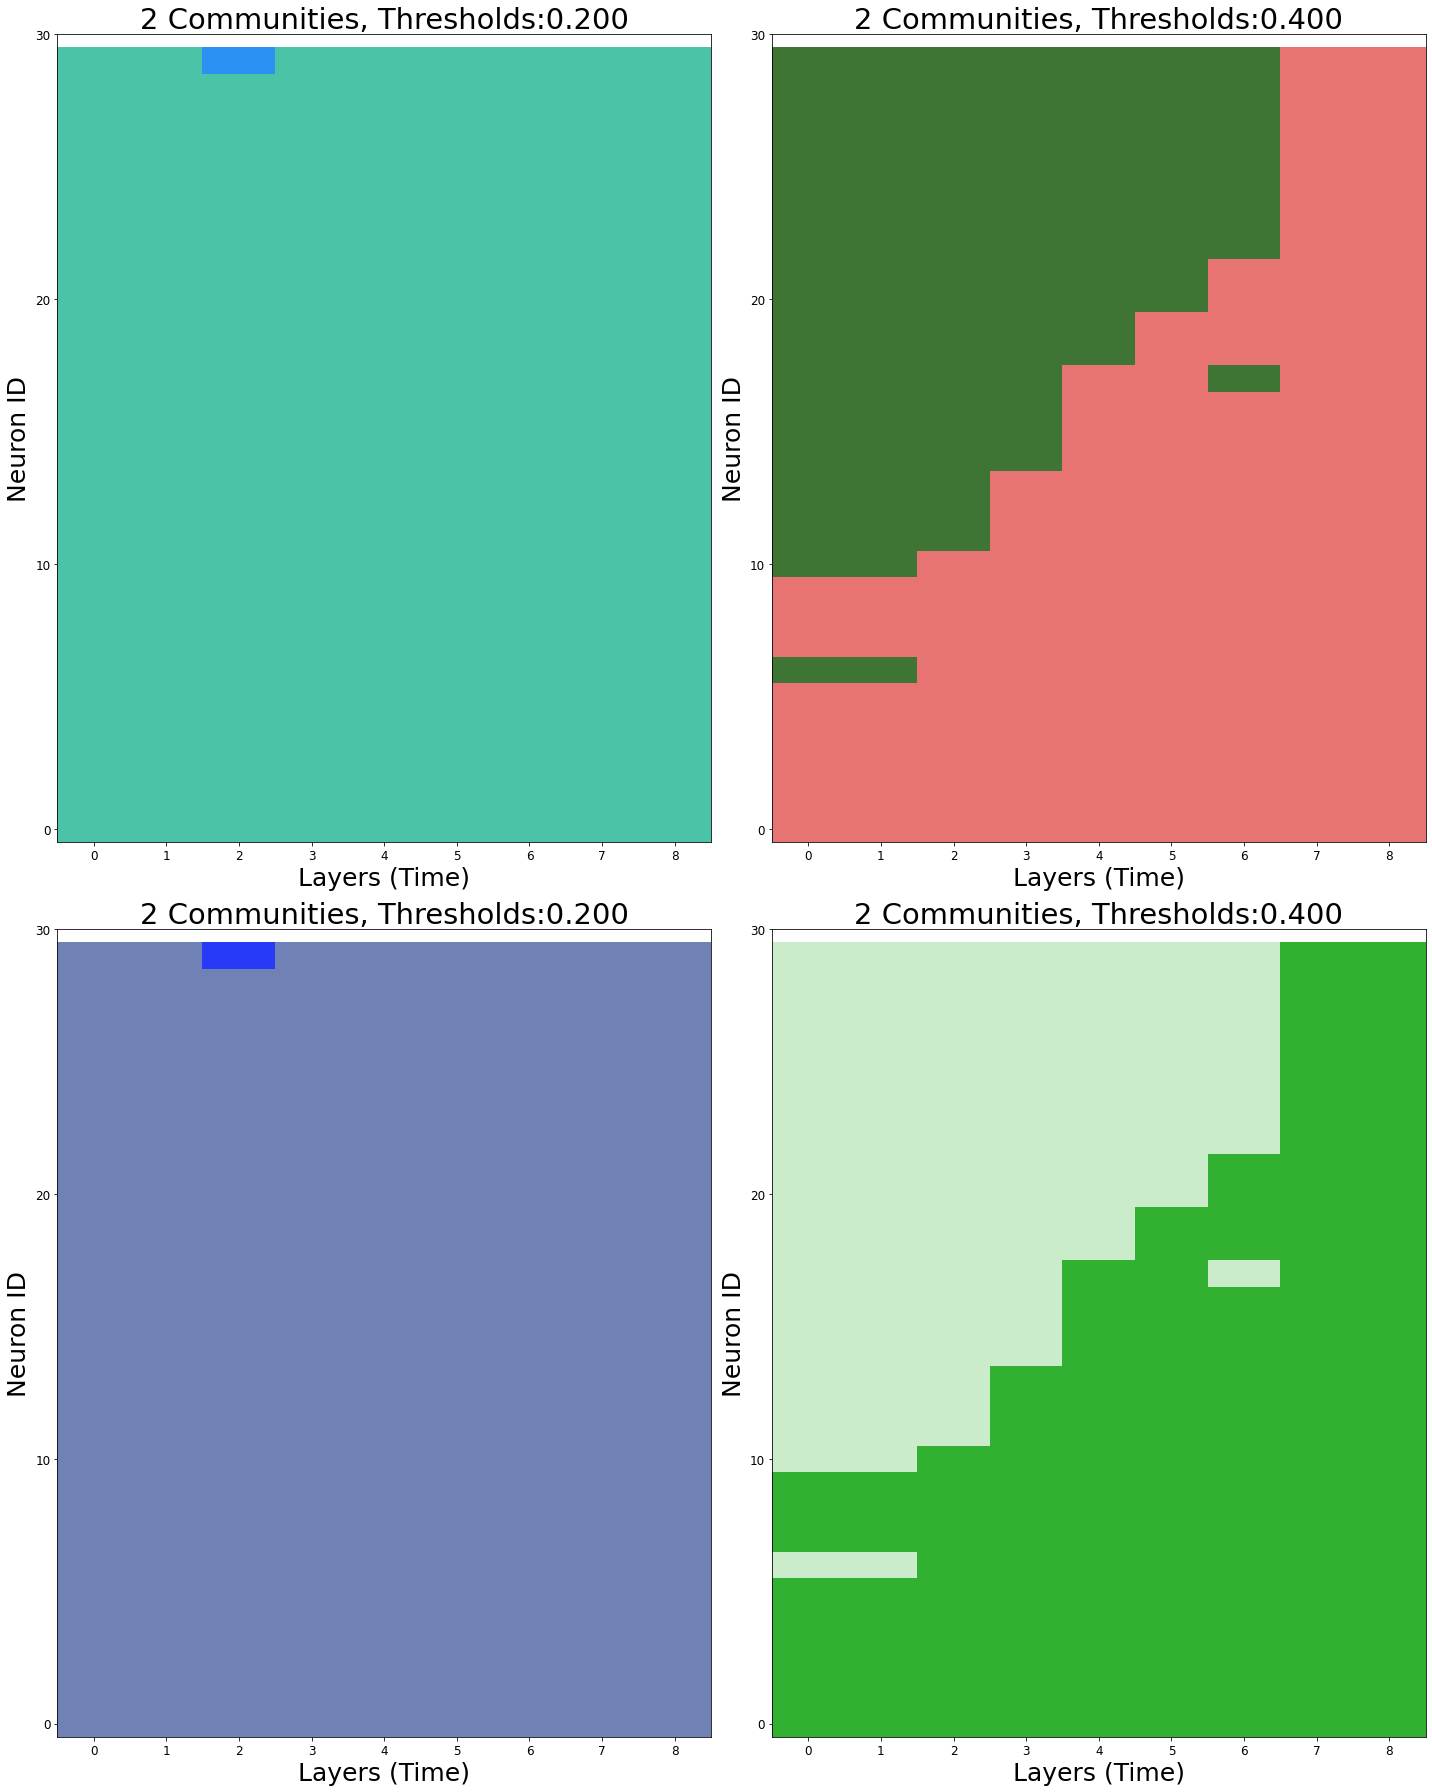

In [19]:
fig,ax = plt.subplots(len(degs),len(threshs), figsize = (10*len(threshs),10*len(degs)+5))
for i in range(len(degs)):
    for j in range(len(threshs)):
        comms, c = TN.community(membership_no_update['degree_correction=%s'%degs[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, Thresholds:%.3f'%(len(c),threshs[j]), fontsize=29)
plt.tight_layout()

(<Figure size 6120x3600 with 4 Axes>,
 array([<AxesSubplot:title={'center':'NMI wrt Scattered Ground Truth'}, xlabel='Threshold', ylabel='Interlayer Coupling'>,
        <AxesSubplot:title={'center':'ARI wrt Scattered Ground Truth'}, xlabel='Threshold', ylabel='Interlayer Coupling'>,
        <AxesSubplot:title={'center':'F1-Score wrt Scattered Ground Truth'}, xlabel='Threshold', ylabel='Interlayer Coupling'>],
       dtype=object))

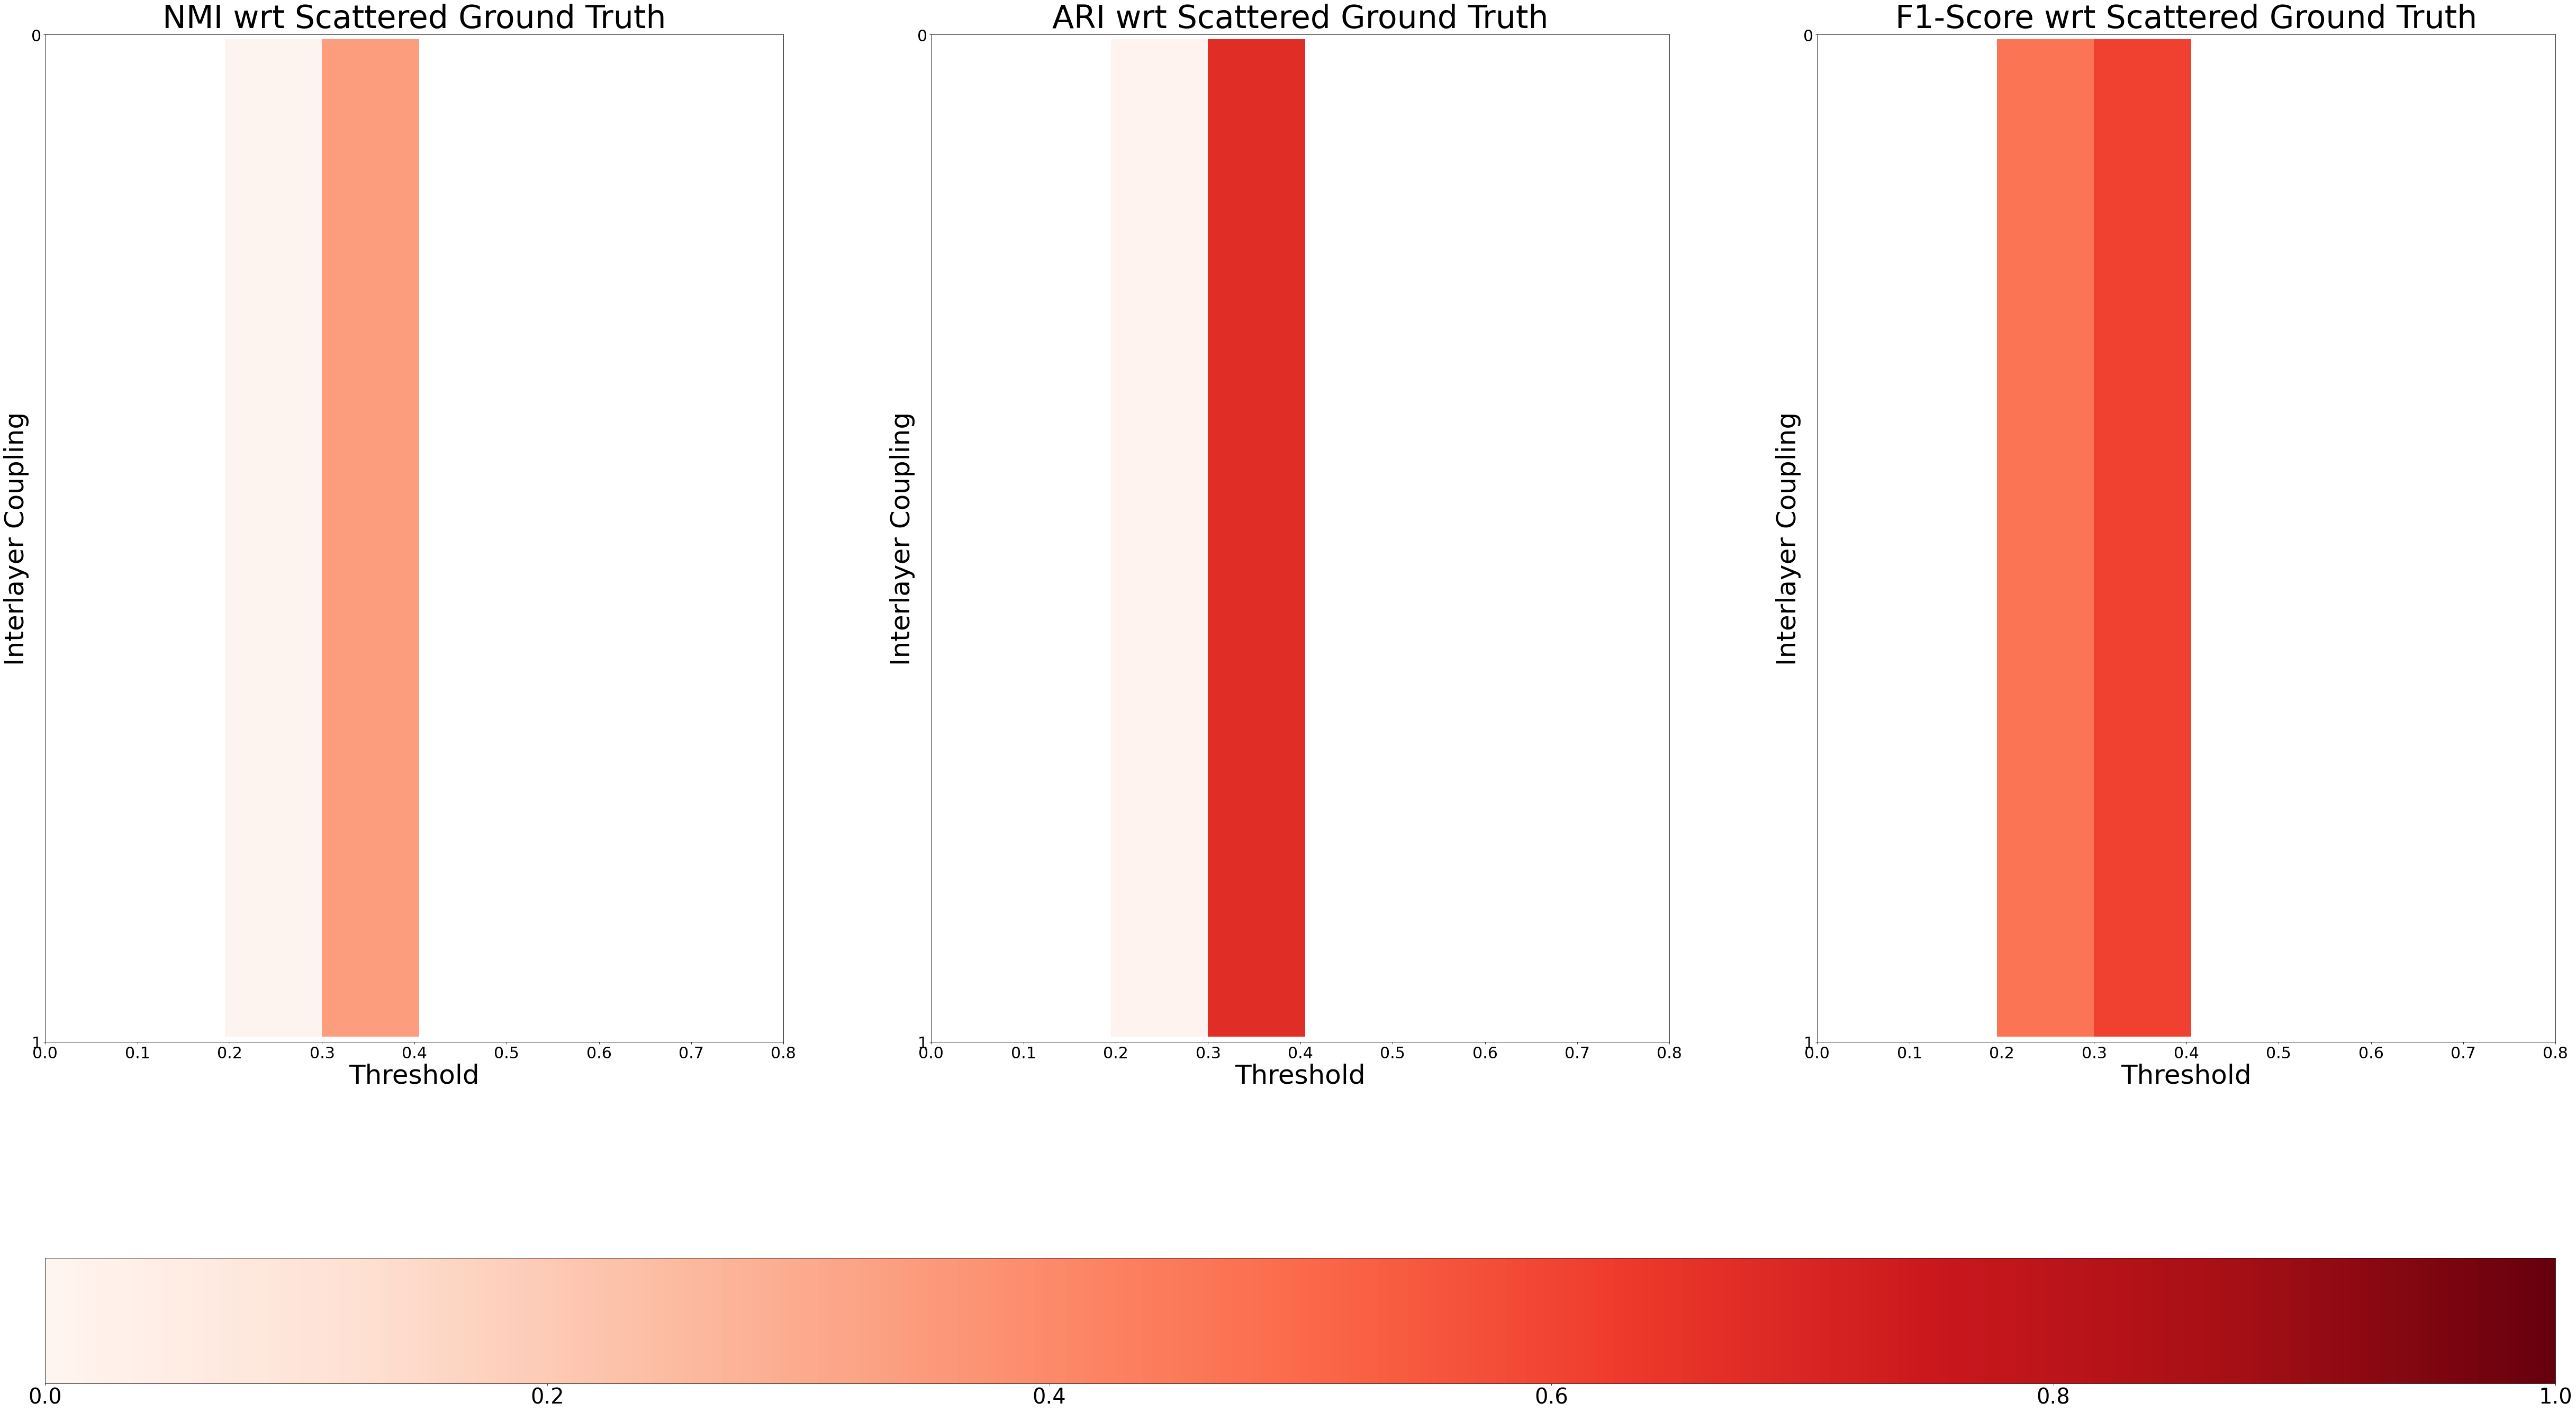

In [20]:
information_recovery(labels_no_update, comm_size, 'Scattered', degs, threshs, 'grow')

## Grow, Tensor Factorization, no update, no consensus

In [ ]:
thresholds = np.linspace(0.3,0.5,6)
ranks = np.arange(2,10)

In [ ]:
%%time
membership_no_update, labels_no_update = TN.run_community_detection('PARA_FACT', ranks = ranks, thresholds = thresholds, update_method = None, consensus = False)

In [ ]:
fig,ax = plt.subplots(len(ranks),len(thresholds), figsize = (10*len(thresholds),10*len(ranks)+5))
for i in range(len(ranks)):
    for j in range(len(thresholds)):
        comms, c = TN.community(membership_no_update['rank=%d'%ranks[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, Thresholds:%.3f'%(len(c),thresholds[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_no_update, comm_size, 'Scattered', ranks, thresholds, 'grow')

In [ ]:
information_recovery(labels_no_update, comm_size, 'Integrated', ranks, thresholds, 'grow')

In [ ]:
display_truth(comm_size, community_operation = 'grow')

## Grow, Tensor Factorization, no update, consensus

In [ ]:
%%time
membership_no_update_consensus, labels_no_update = TN.run_community_detection('PARA_FACT', ranks = ranks, thresholds = thresholds, update_method = None, consensus = True)

In [ ]:
fig,ax = plt.subplots(1,1, figsize = (12,12))
comms, c = TN.community(membership_no_update_consensus, ax)
ax.set_title(r'%d Communities, Consensus over the rectangle Ranks$\in[%d,%d]$ and Thresholds$\in[%.2f,%.2f]$ '%(len(c),ranks[0],ranks[-1],thresholds[0],thresholds[-1]), fontsize=29)
ax.set_xticks([i for i in range(layers)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_xlabel('Layers (Time)', fontsize = 25)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 12)

## Grow, Tensor Factorization, local update, no consensus

In [ ]:
%%time
membership_local_update, labels_local_update = TN.run_community_detection('PARA_FACT', ranks = ranks, thresholds = thresholds, update_method = 'local', spikes = spikes, consensus = False)

In [ ]:
fig,ax = plt.subplots(len(ranks),len(thresholds), figsize = (10*len(thresholds),10*len(ranks)+5))
for i in range(len(ranks)):
    for j in range(len(thresholds)):
        comms, c = TN.community(membership_local_update['rank=%d'%ranks[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, Thresholds:%.3f'%(len(c),thresholds[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_local_update, comm_size, 'Scattered', ranks, thresholds, 'grow')

In [ ]:
information_recovery(labels_local_update, comm_size, 'Integrated', ranks, thresholds, 'grow')

## Grow, Tensor Factorization, neighborhood update, no consensus

In [ ]:
%%time
membership_neighborhood_update, labels_neighborhood_update = TN.run_community_detection('PARA_FACT', ranks = ranks, thresholds = thresholds, update_method = 'neighborhood', spikes = spikes, consensus = False)

In [ ]:
fig,ax = plt.subplots(len(ranks),len(thresholds), figsize = (10*len(thresholds),10*len(ranks)+5))
for i in range(len(ranks)):
    for j in range(len(thresholds)):
        comms, c = TN.community(membership_neighborhood_update['rank=%d'%ranks[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, Thresholds:%.3f'%(len(c),thresholds[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_neighborhood_update, comm_size, 'Scattered', ranks, thresholds, 'grow')

In [ ]:
information_recovery(labels_neighborhood_update, comm_size, 'Integrated', ranks, thresholds, 'grow')

## ------------------------------------------------

## Grow, MMM, no update, no consensus

In [ ]:
grid = 5
ress = np.linspace(0, 2, grid)
inters = np.linspace(0, 1.2, grid)

In [ ]:
membership_no_update, labels_no_update = TN.run_community_detection('MMM', interlayers = inters, resolutions = ress)

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(membership_no_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, resolution:%.3f'%(len(c),inters[i],ress[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_no_update, comm_size, 'Scattered', inters, ress, 'grow')

In [ ]:
information_recovery(labels_no_update, comm_size, 'Integrated', inters, ress, 'grow')

In [ ]:
display_truth(comm_size, community_operation = 'grow')

## Grow, MMM, no update, consensus

In [ ]:
membership_no_update_consensus, labels_no_update = TN.run_community_detection('MMM', interlayers = inters, resolutions = ress, consensus = True)

In [ ]:
fig,ax = plt.subplots(1,1, figsize = (12,12))
comms, c = TN.community(membership_no_update_consensus, ax)
ax.set_title(r'%d Communities, Consensus over the rectangle interlayers$\in[%.2f,%.2f]$ and resolutions$\in[%.2f,%.2f]$ '%(len(c),inters[0],inters[-1],ress[0],ress[-1]), fontsize=29)
ax.set_xticks([i for i in range(layers)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_xlabel('Layers (Time)', fontsize = 25)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 12)

## Grow, MMM, local update, no consensus

In [ ]:
membership_local_update, labels_local_update = TN.run_community_detection('MMM', update_method = 'local', interlayers = inters, resolutions = ress, spikes = spikes)

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(membership_local_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, resolution:%.3f'%(len(c),inters[i],ress[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_local_update, comm_size, 'Scattered', inters, ress, 'grow')

In [ ]:
information_recovery(labels_local_update, comm_size, 'Integrated', inters, ress, 'grow')

## Grow, MMM, global update, no consensus

In [ ]:
membership_global_update, labels_global_update = TN.run_community_detection('MMM', update_method = 'global', interlayers = inters, resolutions = ress, spikes = spikes)

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(membership_global_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, resolution:%.3f'%(len(c),inters[i],ress[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_global_update, comm_size, 'Scattered', inters, ress, 'grow')

In [ ]:
information_recovery(labels_global_update, comm_size, 'Integrated', inters, ress, 'grow')

## Grow, MMM, neighborhood update, no consensus

In [ ]:
membership_neighborhood_update, labels_neighborhood_update = TN.run_community_detection('MMM', update_method = 'neighborhood', interlayers = inters, resolutions = ress, spikes = spikes)

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(membership_neighborhood_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, resolution:%.3f'%(len(c),inters[i],ress[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_neighborhood_update, comm_size, 'Scattered', inters, ress, 'grow')

In [ ]:
information_recovery(labels_neighborhood_update, comm_size, 'Integrated', inters, ress, 'grow')

## -----------------------------------------------------------------

In [ ]:
grid = 5
threshs = np.linspace(0, 0.8, grid)
inters = np.linspace(0, 1.5, grid)

## Grow, infomap, no update, no consensus

In [ ]:
infomap_no_update, infomap_labels_no_update = TN.run_community_detection('infomap', interlayers = inters, thresholds = threshs )

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(infomap_no_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i],threshs[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(infomap_labels_no_update, comm_size, 'Scattered', inters, threshs, 'grow')

In [ ]:
information_recovery(infomap_labels_no_update, comm_size, 'Integrated', inters, threshs, 'grow')

In [ ]:
display_truth(comm_size, community_operation = 'grow')

## Grow, infomap, no update, consensus

In [ ]:
infomap_no_update_consensus, labels_no_update = TN.run_community_detection('infomap', interlayers = inters, thresholds = threshs, consensus = True)

In [ ]:
fig,ax = plt.subplots(1,1, figsize = (12,12))
comms, c = TN.community(infomap_no_update_consensus, ax)
ax.set_title(r'%d Communities, Consensus over the rectangle interlayers$\in[%.2f,%.2f]$ and thresholds$\in[%.2f,%.2f]$ '%(len(c),inters[0],inters[-1],threshs[0],threshs[-1]), fontsize=29)
ax.set_xticks([i for i in range(layers)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_xlabel('Layers (Time)', fontsize = 25)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 12)

## Grow, infomap, local update, no consensus

In [ ]:
infomap_local_update, labels_local_update = TN.run_community_detection('infomap', update_method = 'local', interlayers = inters, thresholds = threshs, spikes = spikes)

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(infomap_local_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i],threshs[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_local_update, comm_size, 'Scattered', inters, threshs, 'grow')

In [ ]:
information_recovery(labels_local_update, comm_size, 'Integrated', inters, threshs, 'grow')

## Grow, infomap, global update, no consensus

In [ ]:
infomap_global_update, labels_global_update = TN.run_community_detection('infomap', update_method = 'global', interlayers = inters, thresholds = threshs, spikes = spikes)

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(infomap_global_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i],threshs[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_global_update, comm_size, 'Scattered', inters, threshs, 'grow')

In [ ]:
information_recovery(labels_global_update, comm_size, 'Integrated', inters, threshs, 'grow')

## Grow, infomap, neighborhood, no consensus

In [ ]:
infomap_nbr_update, labels_nbr_update = TN.run_community_detection('infomap', 
                                                                         update_method = 'neighborhood', 
                                                                   interlayers = inters, thresholds = threshs)

In [ ]:
fig,ax = plt.subplots(grid,grid, figsize = (grid*15+5,grid*15))
for i in range(grid):
    for j in range(grid):
        comms, c = TN.community(infomap_nbr_update['interlayer=%.3f'%inters[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 12)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
        ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i],threshs[j]), fontsize=29)
plt.tight_layout()

In [ ]:
information_recovery(labels_nbr_update, comm_size, 'Scattered', inters, threshs, 'grow')

In [ ]:
information_recovery(labels_nbr_update, comm_size, 'Integrated', inters, threshs, 'grow')